# Шумоподавляющий Автоэнкодер

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [16]:
transform = transforms.Compose([
    transforms.Resize(32,),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(len(dataset) * 0.6)
val_size = int(len(dataset) * 0.2)
test_size = len(dataset) - (val_size + train_size)

generator = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

In [17]:
class DenoisingAE(nn.Module):
  def __init__(self):
    super(DenoisingAE, self).__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 32, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, 3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, 3, stride=2, padding=1),
        nn.ReLU()
    )

    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
def add_noise(images, noise_factor=0.5):
  noisy = images + noise_factor * torch.randn_like(images)
  noisy = torch.clamp(noisy, 0., 1.)
  return noisy

Epoch 1/20: 100%|██████████| 563/563 [02:18<00:00,  4.07it/s]



Epoch 1/20
Train Loss: 0.8967 | Dice: 0.0018 | IoU: 0.0011
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
✔ Model improved. Saved to best_ae_classification.pth


Epoch 2/20: 100%|██████████| 563/563 [02:22<00:00,  3.95it/s]



Epoch 2/20
Train Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
✔ Model improved. Saved to best_ae_classification.pth


Epoch 3/20: 100%|██████████| 563/563 [02:22<00:00,  3.94it/s]



Epoch 3/20
Train Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
✔ Model improved. Saved to best_ae_classification.pth


Epoch 4/20: 100%|██████████| 563/563 [02:22<00:00,  3.94it/s]



Epoch 4/20
Train Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002


Epoch 5/20: 100%|██████████| 563/563 [02:22<00:00,  3.94it/s]



Epoch 5/20
Train Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002


Epoch 6/20: 100%|██████████| 563/563 [02:22<00:00,  3.96it/s]



Epoch 6/20
Train Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
✔ Model improved. Saved to best_ae_classification.pth


Epoch 7/20: 100%|██████████| 563/563 [02:21<00:00,  3.97it/s]



Epoch 7/20
Train Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
✔ Model improved. Saved to best_ae_classification.pth


Epoch 8/20: 100%|██████████| 563/563 [02:21<00:00,  3.97it/s]



Epoch 8/20
Train Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002


Epoch 9/20: 100%|██████████| 563/563 [02:21<00:00,  3.98it/s]



Epoch 9/20
Train Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002


Epoch 10/20: 100%|██████████| 563/563 [02:21<00:00,  3.98it/s]



Epoch 10/20
Train Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
Val   Loss: 0.8796 | Dice: 0.0002 | IoU: 0.0002
⏹ Early stopping triggered!
✅ Best model loaded from best_ae_classification.pth

Test Results:
Test Loss: 0.8800
Dice Coefficient: 0.0002
IoU Score: 0.0002


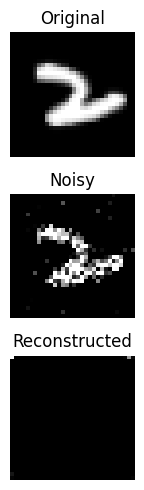

In [14]:
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

patience = 3
best_val_loss = float("inf")
patience_counter = 0
model_path = "best_ae_classification.pth"

def dice_coeff(pred, target):
  smooth = 1
  pred_flat = pred.view(-1)
  target_flat = target.view(-1)
  intersection = (pred_flat * target_flat).sum()
  return (2 * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

def iou_score(pred, target):
  smooth = 1
  pred_flat = pred.view(-1)
  target_flat = target.view(-1)
  intersection = (pred_flat * target_flat).sum()
  union = pred_flat.sum() + target_flat.sum() - intersection
  return (intersection + smooth) / (union + smooth)

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    running_dice = 0.0
    running_iou = 0.0

    for clean_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        clean_images = clean_images.to(device)
        noisy_images = add_noise(clean_images)

        optimizer.zero_grad()
        outputs = model(noisy_images)

        loss = criterion(outputs, clean_images)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        outputs_bin = (outputs > 0.5).float()
        clean_bin = (clean_images > 0.5).float()

        running_dice += dice_coeff(outputs_bin, clean_bin)
        running_iou += iou_score(outputs_bin, clean_bin)

    train_loss = running_loss / len(train_loader)
    train_dice = running_dice / len(train_loader)
    train_iou = running_iou / len(train_loader)

    model.eval()
    val_loss = 0.0
    val_dice = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for clean_images, _ in val_loader:
            clean_images = clean_images.to(device)
            noisy_images = add_noise(clean_images)
            outputs = model(noisy_images)

            val_loss += criterion(outputs, clean_images).item()

            outputs_bin = (outputs > 0.5).float()
            clean_bin = (clean_images > 0.5).float()

            val_dice += dice_coeff(outputs_bin, clean_bin)
            val_iou += iou_score(outputs_bin, clean_bin)

    val_loss /= len(val_loader)
    val_dice /= len(val_loader)
    val_iou /= len(val_loader)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | IoU: {train_iou:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), model_path)
        print(f"✔ Model improved. Saved to {model_path}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("⏹ Early stopping triggered!")
            break

model.load_state_dict(torch.load(model_path))
model.to(device)
print(f"✅ Best model loaded from {model_path}")

model.eval()
test_loss = 0.0
test_dice = 0.0
test_iou = 0.0

with torch.no_grad():
    for clean_images, _ in test_loader:
        clean_images = clean_images.to(device)
        noisy_images = add_noise(clean_images)
        outputs = model(noisy_images)

        test_loss += criterion(outputs, clean_images).item()

        outputs_bin = (outputs > 0.5).float()
        clean_bin = (clean_images > 0.5).float()

        test_dice += dice_coeff(outputs_bin, clean_bin)
        test_iou += iou_score(outputs_bin, clean_bin)

test_loss /= len(test_loader)
test_dice /= len(test_loader)
test_iou /= len(test_loader)

print("\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Dice Coefficient: {test_dice:.4f}")
print(f"IoU Score: {test_iou:.4f}")



def plot_results(model, test_loader, device, num_images=1):
    model.eval()
    with torch.no_grad():
        data = next(iter(test_loader))
        clean_images, _ = data
        clean_images = clean_images[:num_images].to(device)
        noisy_images = add_noise(clean_images)
        outputs = model(noisy_images)

        plt.figure(figsize=(15, 5))
        for i in range(num_images):
            plt.subplot(3, num_images, i+1)
            plt.imshow(clean_images[i].cpu().squeeze(), cmap='gray')
            plt.title("Original")
            plt.axis('off')

            plt.subplot(3, num_images, num_images+i+1)
            plt.imshow(noisy_images[i].cpu().squeeze(), cmap='gray')
            plt.title("Noisy")
            plt.axis('off')

            plt.subplot(3, num_images, 2*num_images+i+1)
            plt.imshow(outputs[i].cpu().squeeze(), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')

        plt.tight_layout()
        plt.show()

plot_results(model, test_loader, device)